In [57]:
import pandas as pd
import os 
import numpy as np
import datetime as dt 
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import nbformat
import sklearn
import plotly

In [58]:
project_path = os.getcwd()
doc_path = os.path.join(project_path, "dataset")
fichiers = os.listdir(doc_path)

cutsomers = pd.read_csv(os.path.join(doc_path, fichiers[0]))
geolocalisation = pd.read_csv(os.path.join(doc_path, fichiers[1]))
orders_dataset = pd.read_csv(os.path.join(doc_path, fichiers[2]))
order_items = pd.read_csv(os.path.join(doc_path, fichiers[3]))
order_payment = pd.read_csv(os.path.join(doc_path, fichiers[4]))
orders_reviews = pd.read_csv(os.path.join(doc_path, fichiers[5]))
products = pd.read_csv(os.path.join(doc_path, fichiers[6]))
sellers = pd.read_csv(os.path.join(doc_path, fichiers[7]))
product_category_name_transalation = pd.read_csv(os.path.join(doc_path, fichiers[8]))

In [59]:
customer_orders = pd.merge(orders_dataset, cutsomers, on = "customer_id", how = "inner")
customer_orders.head()



,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [ ]:

customer_orders.groupby("customer_unique_id").agg({"order_id": "count"}).sort_values(by = "order_id", ascending = False).head(100)
only_unique_customers = customer_orders[customer_orders.groupby('customer_unique_id').customer_unique_id.transform('count')>1].copy() 
display(only_unique_customers.head())
only_unique_customers.groupby("customer_unique_id").agg({"order_id": "count"}).sort_values(by = "order_id", ascending = False).head(100)



In [ ]:
def get_month(x): return dt.datetime(x.year, x.month, 1)



In [ ]:

only_unique_customers['order_purchase_timestamp'] = pd.to_datetime(only_unique_customers['order_purchase_timestamp'])
only_unique_customers['InvoiceDate'] = [d.date() for d in only_unique_customers["order_purchase_timestamp"]]



In [ ]:

print('min:{}; Max:{}'.format(min(only_unique_customers['InvoiceDate']), max(only_unique_customers['InvoiceDate'])))
snapshot_date = max(only_unique_customers['InvoiceDate']) + dt.timedelta(days=1)
order_customer_paiement = pd.merge(only_unique_customers, order_payment,  on = "order_id", how = "inner")
order_customer_paiement_review = pd.merge(order_customer_paiement, orders_reviews,  on = "order_id", how = "inner")



In [ ]:

# set the start and end date for the filter
start_date = pd.to_datetime('2017-01-01').date()
end_date = pd.to_datetime('2018-01-01').date()


# filter the dataframe by date range
order_customer_paiement_review = order_customer_paiement_review.loc[(order_customer_paiement_review['InvoiceDate'] > start_date) & (order_customer_paiement_review['InvoiceDate'] < end_date)]


## Get RFM values

In [71]:
data = order_customer_paiement_review.groupby(['customer_unique_id']).agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days,"order_id": "count", "payment_value": "sum", "review_score": "mean", "review_comment_message": lambda x: np.mean(len(x)), "payment_installments": "mean"})

In [72]:
data.head()

,InvoiceDate,order_id,payment_value,review_score,review_comment_message,payment_installments
customer_unique_id,,,,,,
004288347e5e88a27ded2bb23747066c,447,1,251.09,5.0,1.0,2.0
004b45ec5c64187465168251cd1c9c2f,411,1,97.87,1.0,1.0,1.0
00cc12a6d8b578b8ebd21ea4e2ae8b27,575,4,252.40,4.0,4.0,1.0
011b4adcd54683b480c4d841250a987f,421,1,86.42,5.0,1.0,8.0
012452d40dafae4df401bced74cdb490,486,1,155.26,4.0,1.0,5.0


In [73]:
data.rename(columns = {'InvoiceDate': 'Recency', 'order_id': 'Frequency', 'payment_value': 'MonetaryValue'}, inplace = True)

In [74]:
data.head()

,Recency,Frequency,MonetaryValue,review_score,review_comment_message,payment_installments
customer_unique_id,,,,,,
004288347e5e88a27ded2bb23747066c,447,1,251.09,5.0,1.0,2.0
004b45ec5c64187465168251cd1c9c2f,411,1,97.87,1.0,1.0,1.0
00cc12a6d8b578b8ebd21ea4e2ae8b27,575,4,252.40,4.0,4.0,1.0
011b4adcd54683b480c4d841250a987f,421,1,86.42,5.0,1.0,8.0
012452d40dafae4df401bced74cdb490,486,1,155.26,4.0,1.0,5.0


In [75]:
r_labels = [4,3,2,1]
f_labels = [1,2,3,4]
m_labels = [1,2,3,4]

In [76]:
r_quartiles = pd.qcut(data['Recency'], q=4, labels=r_labels, duplicates='drop')


In [77]:
f_quartiles = pd.qcut(data.Frequency.rank(method='first'), 4, labels=f_labels)
print(f_quartiles)

customer_unique_id
004288347e5e88a27ded2bb23747066c    1
004b45ec5c64187465168251cd1c9c2f    1
00cc12a6d8b578b8ebd21ea4e2ae8b27    4
011b4adcd54683b480c4d841250a987f    1
012452d40dafae4df401bced74cdb490    1
                                   ..
fed519569d16e690df6f89cb99d4e682    2
ff44401d0d8f5b9c54a47374eb48c1b8    4
ff8892f7c26aa0446da53d01b18df463    4
ff922bdd6bafcdf99cb90d7f39cea5b3    4
ffe254cc039740e17dd15a5305035928    4
Name: Frequency, Length: 1863, dtype: category
Categories (4, int64): [1 < 2 < 3 < 4]


In [78]:
m_quartiles = pd.qcut(data['MonetaryValue'], q=4, labels=m_labels)

In [79]:
data = data.assign(R = r_quartiles.values, F = f_quartiles.values, M = m_quartiles.values)

In [80]:
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])


In [81]:
data['RFM_segment'] = data.apply(join_rfm, axis=1)
data["RFM_score"] = data[["R", "F", "M"]].sum(axis=1)
data.head()

,Recency,Frequency,MonetaryValue,review_score,review_comment_message,payment_installments,R,F,M,RFM_segment,RFM_score
customer_unique_id,,,,,,,,,,,
004288347e5e88a27ded2bb23747066c,447,1,251.09,5.0,1.0,2.0,2,1,3,2.01.03.0,6
004b45ec5c64187465168251cd1c9c2f,411,1,97.87,1.0,1.0,1.0,2,1,1,2.01.01.0,4
00cc12a6d8b578b8ebd21ea4e2ae8b27,575,4,252.40,4.0,4.0,1.0,1,4,3,1.04.03.0,8
011b4adcd54683b480c4d841250a987f,421,1,86.42,5.0,1.0,8.0,2,1,1,2.01.01.0,4
012452d40dafae4df401bced74cdb490,486,1,155.26,4.0,1.0,5.0,1,1,2,1.01.02.0,4


In [82]:
data.groupby('RFM_score').agg({'Recency': 'mean', 'Frequency': 'mean', 'MonetaryValue': ['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_score                                      
3           549.0       1.0          60.8    63
4           495.1       1.1          85.5   133
5           458.5       1.3         112.1   178
6           435.3       1.5         132.1   265
7           424.5       1.9         196.1   261
8           407.2       2.2         307.9   301
9           400.1       2.6         365.8   307
10          364.8       2.7         448.9   181
11          336.5       2.8         508.5   121
12          317.9       3.5         686.3    53

In [83]:
def segment_me(df):
    if df['RFM_score'] >= 9:
        return 'Gold'
    elif ((df['RFM_score'] >= 8) and (df['RFM_score'] < 9)):
        return 'Silver'
    elif ((df['RFM_score'] >= 4) and (df['RFM_score'] < 8)):
        return 'Bronze'
    else: 
        return 'Copper'


In [84]:
data['General_Segment'] = data.apply(segment_me, axis=1)
data.groupby('General_Segment').agg({'Recency': 'mean', 'Frequency': 'mean', 'MonetaryValue': ['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Bronze            446.4       1.5         140.4   837
Copper            549.0       1.0          60.8    63
Gold              372.2       2.7         440.3   662
Silver            407.2       2.2         307.9   301

In [85]:
RFM = data[['Recency', 'Frequency', 'MonetaryValue']]
data_predict = data[['Recency', 'Frequency', 'MonetaryValue', 'review_score', 'review_comment_message', 'payment_installments']]


## Change variables for more symetrie and centering and scaling

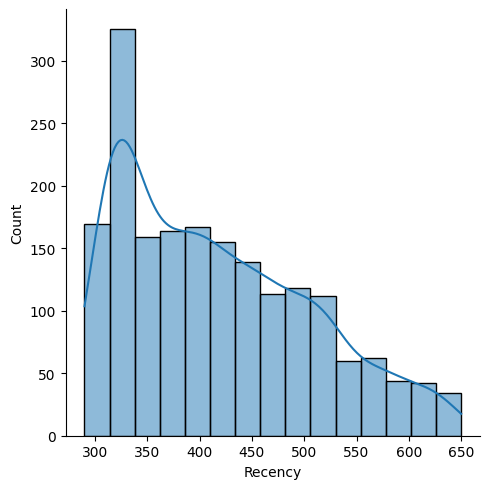

In [86]:
sns.displot(data['Recency'], kde=True)
plt.show()

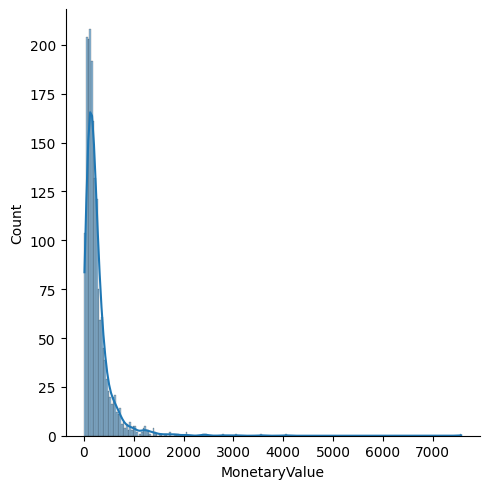

In [87]:
sns.displot(data['MonetaryValue'], kde=True)
plt.show()

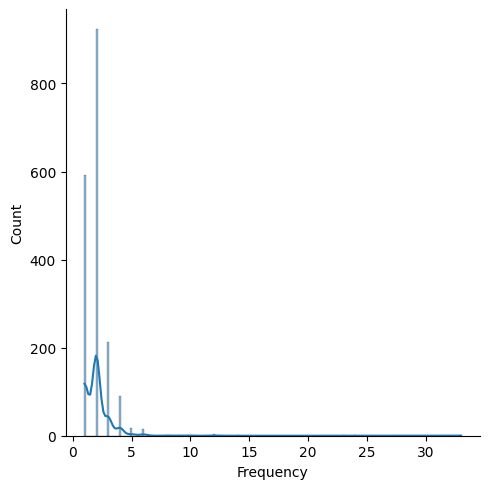

In [88]:
sns.displot(data['Frequency'], kde=True)
plt.show()

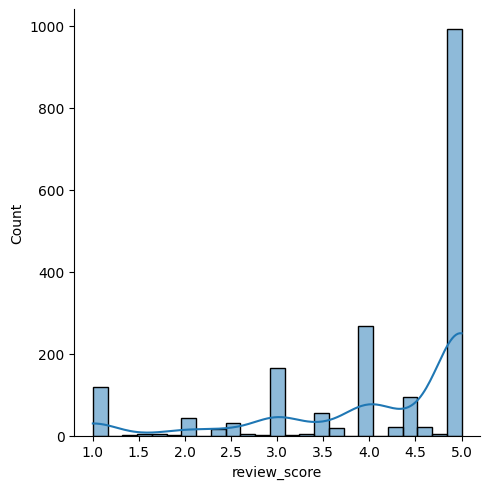

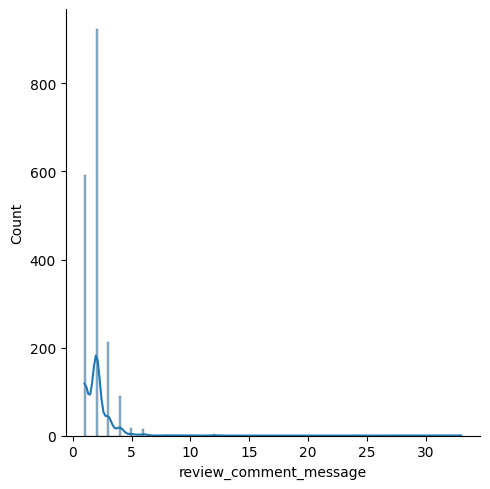

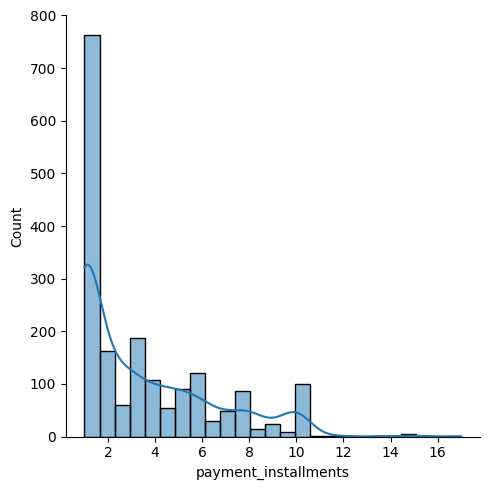

In [89]:
sns.displot(data['review_score'], kde=True)
sns.displot(data['review_comment_message'], kde=True)
sns.displot(data['payment_installments'], kde=True)


In [90]:
#unskew data
frequency_log = np.log(data['Frequency'])
monetary_log = np.log(data['MonetaryValue'])
recency_log = np.log(data['Recency'])
review_score_log = np.log(data['review_score'])
review_message_log = np.log(data['review_comment_message'])
payment_installments_log = np.log(data['payment_installments'])


In [91]:
data['Frequency'] = frequency_log
data['MonetaryValue'] = monetary_log
data['Recency'] = recency_log
data['review_score'] = review_score_log
data['review_comment_message'] = review_message_log
data['payment_installments'] = payment_installments_log

In [92]:
data_RFM = data[['Recency', 'Frequency', 'MonetaryValue', 'RFM_score', 'payment_installments', 'review_score','review_comment_message', 'General_Segment']]
RFM = data_RFM[['Recency', 'Frequency', 'MonetaryValue', 'payment_installments', 'review_score', 'review_comment_message']]


In [93]:
from sklearn.preprocessing import StandardScaler

#center and scale data
scaler = StandardScaler()
scaler.fit(RFM)

#store for clustering
data_scaled = scaler.transform(RFM)
print('mean:', data_scaled.mean(axis=0).round(2))
print('std:', data_scaled.std(axis=0).round(2))

mean: [-0. -0. -0. -0.  0. -0.]
std: [1. 1. 1. 1. 1. 1.]


# Started clustering experiments

In [ ]:
mlflow.tracking.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Eclient segmentation")



2023/04/09 17:59:10 INFO mlflow.tracking.fluent: Experiment with name 'Eclient segmentation' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/377592725585441763', creation_time=1681055950959, experiment_id='377592725585441763', last_update_time=1681055950959, lifecycle_stage='active', name='Eclient segmentation', tags={}>

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k).fit(data_scaled)
    RFM["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center


c:\Users\litle\repos\eclient_segmentation\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\litle\AppData\Local\Temp\ipykernel_26884\361126633.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RFM["clusters"] = kmeans.labels_
c:\Users\litle\repos\eclient_segmentation\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\litle\AppData\Local\Temp\ipykernel_26884\361126633.py:7: SettingWithCopyWarning: 
A 

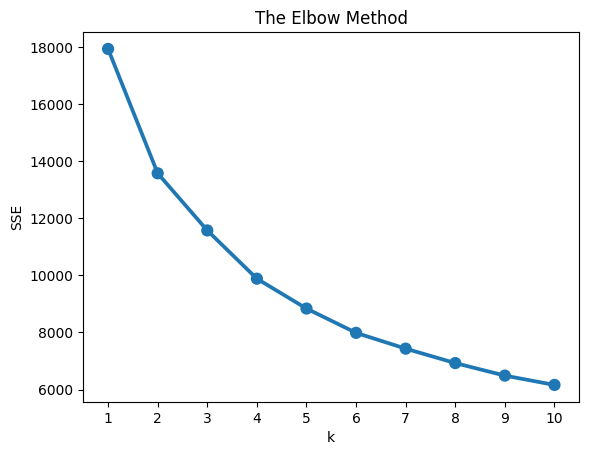

In [ ]:
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [ ]:
for i in [2,3, 4, 5]:
    name = 'Kmeans' + str(i)
    with mlflow.start_run(run_name=name):
        kmeans = KMeans(n_clusters= i, random_state = 1).fit(data_scaled)
        cluster_labels = kmeans.labels_
        mlflow.log_metric("silhouette_score", silhouette_score(data_scaled, cluster_labels))
        mlflow.log_param("n_clusters", i)
        mlflow.log_param("random_state", 1)
        mlflow.end_run()
    
    


c:\Users\litle\repos\eclient_segmentation\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\litle\repos\eclient_segmentation\.venv\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'kmeans'.
2023/04/09 17:59:33 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: kmeans, version 1
Created version '1' of model 'kmeans'.
c:\Users\litle\repos\eclient_segmentation\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Registered model 'kmeans

In [ ]:
from sklearn.cluster import MeanShift
for i in [200, 400, 600, 800]:
    name = 'nameshift' + str(i)
    with mlflow.start_run(run_name=name):
        mean_shift = MeanShift(max_iter = i, n_jobs= - 1).fit(data_scaled)
        cluster_labels = mean_shift.labels_
        mlflow.log_metric("silhouette_score", silhouette_score(data_scaled, cluster_labels))
        mlflow.log_param("max_iter", i)
        mlflow.log_param("n_jobs", -1)
        mlflow.log_param("n_clusters", len(np.unique(cluster_labels)))
        mlflow.end_run()

Successfully registered model 'mean_shift'.
2023/04/09 18:00:33 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: mean_shift, version 1
Created version '1' of model 'mean_shift'.
Registered model 'mean_shift' already exists. Creating a new version of this model...
2023/04/09 18:00:53 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: mean_shift, version 2
Created version '2' of model 'mean_shift'.
Registered model 'mean_shift' already exists. Creating a new version of this model...
2023/04/09 18:01:12 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: mean_shift, version 3
Created version '3' of model 'mean_shift'.
Registered model 'mean_shift' already exists. Creating a new version of this model...
2023/04/09 18:01:29 

In [ ]:
from sklearn.cluster import DBSCAN
max_distance = [0.1, 0.2, 0.3, 0.4]
min_samples = [2, 3, 4, 5]
for i in max_distance:
    for j in min_samples:
        name = 'DBSCAN' + str(i) + str(j)
        with mlflow.start_run(run_name=name):
            dbscan = DBSCAN(eps = i, min_samples = j).fit(data_scaled)
            cluster_labels = dbscan.labels_
            mlflow.log_metric("silhouette_score", silhouette_score(data_scaled, cluster_labels))
            mlflow.log_param("eps", i)
            mlflow.log_param("min_samples", j)
            mlflow.log_param("n_clusters", len(np.unique(cluster_labels)))
            mlflow.end_run()
        
        



2023/04/09 18:01:30 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
Successfully registered model 'dbscan'.
2023/04/09 18:01:36 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: dbscan, version 1
Created version '1' of model 'dbscan'.
2023/04/09 18:01:37 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
Registered model 'dbscan' already exists. Creating a new version of this model...
2023/04/09 18:01:43 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: dbscan, version 2
Created version '2' of model 'dbscan'.
2023/04/09 18:01:43 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
Registered model 'dbscan' already exists. Creating a new version of this model...
2023/04/0

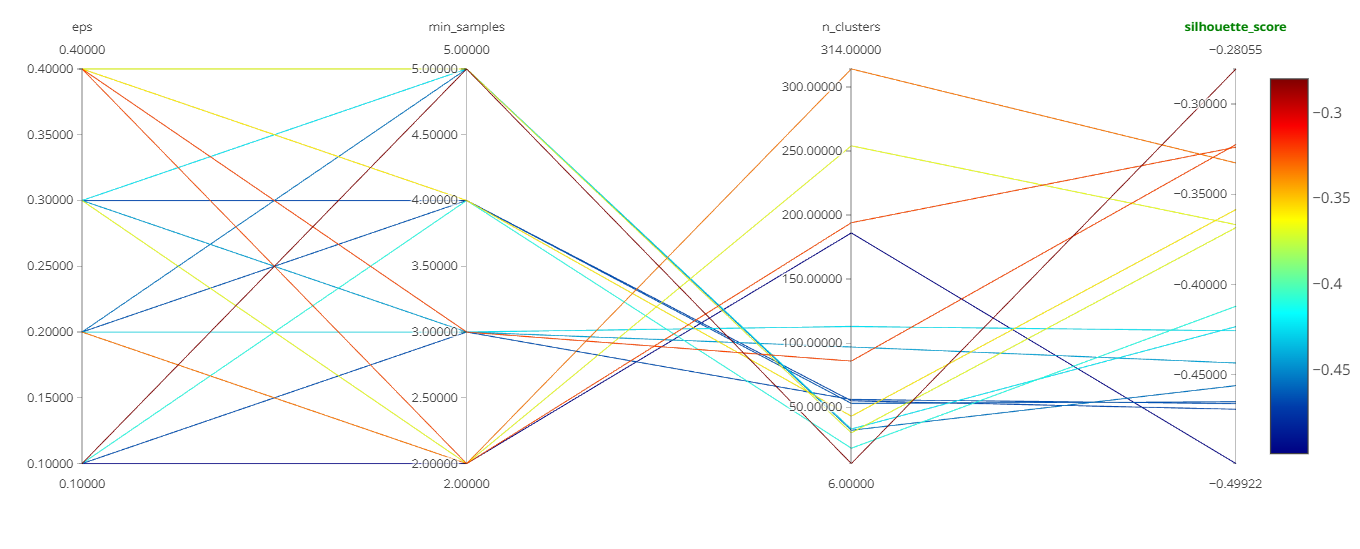

In [38]:
runs = mlflow.search_runs(experiment_names= ["Eclient segmentation"] ).sort_values("metrics.silhouette_score", ascending=False).head(5)
top_models = runs[['tags.mlflow.runName', 'metrics.silhouette_score', 'params.n_clusters']]


In [94]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters= 4).fit(data_scaled)
clusters = model.predict(data_scaled)
data_RFM['clusters'] = clusters
print(data_RFM['clusters'].value_counts())
data['clusters'] = clusters



c:\Users\litle\repos\eclient_segmentation\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


clusters
1    621
2    559
3    531
0    152
Name: count, dtype: int64


C:\Users\litle\AppData\Local\Temp\ipykernel_30408\2909367387.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_RFM['clusters'] = clusters


In [95]:
import plotly.graph_objects as go

PLOT = go.Figure()

for C in list(data.clusters.unique()):
    
    PLOT.add_trace(go.Scatter3d(x = data[data.clusters == C]['Recency'],
                                z = data[data.clusters == C]['Frequency'],
                                y = data[data.clusters == C]['MonetaryValue'],
                                mode = 'markers', marker_size = 8, marker_line_width = 1,
                                name = 'Cluster ' + str(C)))


PLOT.update_layout(width = 800, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'Recency', titlefont_color = 'black'),
                                zaxis=dict(title = 'Frequency', titlefont_color = 'black'),
                                yaxis=dict(title = 'MonetaryValue', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12),
                   margin = dict(l = 0, r = 30, b = 0, t = 0))



In [96]:
import plotly.graph_objects as go

PLOT = go.Figure()

for C in list(data.clusters.unique()):
    
    PLOT.add_trace(go.Scatter3d(x = data[data.clusters == C]['payment_installments'],
                                y = data[data.clusters == C]['review_score'],
                                z = data[data.clusters == C]['review_comment_message'],
                                mode = 'markers', marker_size = 8, marker_line_width = 1,
                                name = 'Cluster ' + str(C)))


PLOT.update_layout(width = 800, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'payment_installments', titlefont_color = 'black'),
                                yaxis=dict(title = 'review_score', titlefont_color = 'black'),
                                zaxis=dict(title = 'review_comment_message', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))


PLOT.update_yaxes(automargin=True)
PLOT.update_xaxes(automargin=True)

In [46]:
data.groupby('clusters').agg({'Recency': 'mean', 'Frequency': 'mean', 'MonetaryValue': ['mean', 'sum'], 'review_score': ['mean', 'count'], 'review_comment_message': ['mean', 'count'], 'payment_installments': ['mean', 'count']}).round(3)

Recency Frequency MonetaryValue           review_score         
            mean      mean          mean       sum         mean count   
clusters                                                                
0          5.460     0.686         5.722  5418.369        1.445   947  \
1          5.329     0.686         5.148  5940.249        1.469  1154   
2          5.526     1.267         5.823  3732.462        1.432   641   
3          5.400     0.760         5.577  1371.949        0.246   246   

         review_comment_message       payment_installments        
                           mean count                 mean count  
clusters                                                          
0                         0.686   947                1.611   947  
1                         0.686  1154                0.267  1154  
2                         1.267   641                0.857   641  
3                         0.760   246                0.843   246

## Meanshift algo

In [48]:
from sklearn.cluster import MeanShift
model = MeanShift().fit(data_scaled)
clusters = model.predict(data_scaled)
data_RFM['clusters'] = clusters
print(data_RFM['clusters'].value_counts())
data['clusters'] = clusters



clusters
0    2896
1      30
4      25
5      20
3      10
2       6
6       1
Name: count, dtype: int64


C:\Users\litle\AppData\Local\Temp\ipykernel_19244\897741874.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [110]:
import plotly.graph_objects as go

PLOT = go.Figure()

for C in list(data.clusters.unique()):
    
    PLOT.add_trace(go.Scatter3d(x = data[data.clusters == C]['Recency'],
                                y = data[data.clusters == C]['Frequency'],
                                z = data[data.clusters == C]['MonetaryValue'],
                                mode = 'markers', marker_size = 8, marker_line_width = 1,
                                name = 'Cluster ' + str(C)))


PLOT.update_layout(width = 800, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'Recency', titlefont_color = 'black'),
                                yaxis=dict(title = 'Frequency', titlefont_color = 'black'),
                                zaxis=dict(title = 'MonetaryValue', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))


PLOT.update_yaxes(automargin=True)
PLOT.update_xaxes(automargin=True)



In [111]:
import plotly.graph_objects as go

PLOT = go.Figure()

for C in list(data.clusters.unique()):
    
    PLOT.add_trace(go.Scatter3d(x = data[data.clusters == C]['payment_installments'],
                                y = data[data.clusters == C]['review_score'],
                                z = data[data.clusters == C]['review_comment_message'],
                                mode = 'markers', marker_size = 8, marker_line_width = 1,
                                name = 'Cluster ' + str(C)))


PLOT.update_layout(width = 800, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'payment_installments', titlefont_color = 'black'),
                                yaxis=dict(title = 'review_score', titlefont_color = 'black'),
                                zaxis=dict(title = 'review_comment_message', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))


PLOT.update_yaxes(automargin=True)
PLOT.update_xaxes(automargin=True)


In [97]:
data.groupby('clusters').agg({'Recency': 'mean', 'Frequency': 'mean', 'MonetaryValue': ['mean', 'sum'], 'review_score': ['mean', 'count'], 'review_comment_message': ['mean', 'count'], 'payment_installments': ['mean', 'count']}).round(3)

Recency Frequency MonetaryValue           review_score         
            mean      mean          mean       sum         mean count   
clusters                                                                
0          6.011     0.473         5.095   774.489        0.139   152  \
1          6.008     0.866         5.195  3226.354        1.464   621   
2          5.998     0.848         5.813  3249.339        1.435   559   
3          6.027     0.000         4.641  2464.592        1.513   531   

         review_comment_message       payment_installments        
                           mean count                 mean count  
clusters                                                          
0                         0.473   152                0.710   152  
1                         0.866   621                0.266   621  
2                         0.848   559                1.671   559  
3                         0.000   531                0.879   531

## Final visualisation

In [98]:

model = KMeans(n_clusters= 4).fit(data_scaled)
clusters = model.predict(data_scaled)
data_RFM['clusters'] = clusters
data['clusters'] = clusters

c:\Users\litle\repos\eclient_segmentation\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\litle\AppData\Local\Temp\ipykernel_30408\1548218199.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [99]:
data_normalized = pd.DataFrame(data_scaled, index=RFM.index, columns=['Recency', 'Frequency', 'MonetaryValue', 'payment_installments', 'review_score', 'review_comment_message'])


data_normalized['Cluster'] = data['clusters']

In [100]:
data_normalized.head(100)

,Recency,Frequency,MonetaryValue,payment_installments,review_score,review_comment_message,Cluster
customer_unique_id,,,,,,,
004288347e5e88a27ded2bb23747066c,0.434363,-1.229319,0.365147,-0.248233,0.585888,-1.229319,0
004b45ec5c64187465168251cd1c9c2f,0.036790,-1.229319,-0.740263,-1.085810,-3.211601,-1.229319,1
00cc12a6d8b578b8ebd21ea4e2ae8b27,1.626683,1.700526,0.371253,-1.085810,0.059378,1.700526,3
011b4adcd54683b480c4d841250a987f,0.150617,-1.229319,-0.886241,1.426921,0.585888,-1.229319,0
012452d40dafae4df401bced74cdb490,0.830444,-1.229319,-0.198850,0.858983,0.059378,-1.229319,0
...,...,...,...,...,...,...,...
0d57344e9e4e9d16dc699cb417e50cb0,-1.002539,0.235604,0.444981,-1.085810,0.585888,0.235604,3
0d997d092f93b5c58d0f9b4bd0643d16,-1.148242,0.235604,-0.387138,0.731669,0.337289,0.235604,2
0dd933d1e0253343083013791bf5d5e9,-1.045781,1.700526,0.126636,0.241718,0.585888,1.700526,2


In [101]:
data_melt = pd.melt(data_normalized.reset_index(), id_vars=['customer_unique_id', 'Cluster'], value_vars=['Recency', 'Frequency', 'MonetaryValue', 'payment_installments', 'review_score', 'review_comment_message'], var_name='Attribute', value_name='Value')

In [102]:
data_melt.head()

,customer_unique_id,Cluster,Attribute,Value
0,004288347e5e88a27ded2bb23747066c,0,Recency,0.434363
1,004b45ec5c64187465168251cd1c9c2f,1,Recency,0.036790
2,00cc12a6d8b578b8ebd21ea4e2ae8b27,3,Recency,1.626683
3,011b4adcd54683b480c4d841250a987f,0,Recency,0.150617
4,012452d40dafae4df401bced74cdb490,0,Recency,0.830444


In [103]:
data_melt_rfm_score = data_normalized.assign(General_Segment = data['General_Segment'])


data_melt_rfm_score = pd.melt(data_melt_rfm_score.reset_index(), id_vars=['customer_unique_id', 'General_Segment'], value_vars=['Recency', 'Frequency', 'MonetaryValue', 'payment_installments', 'review_score', 'review_comment_message'], var_name='Attribute', value_name='Value')

data_melt_rfm_score.head()


,customer_unique_id,General_Segment,Attribute,Value
0,004288347e5e88a27ded2bb23747066c,Bronze,Recency,0.434363
1,004b45ec5c64187465168251cd1c9c2f,Bronze,Recency,0.036790
2,00cc12a6d8b578b8ebd21ea4e2ae8b27,Silver,Recency,1.626683
3,011b4adcd54683b480c4d841250a987f,Bronze,Recency,0.150617
4,012452d40dafae4df401bced74cdb490,Bronze,Recency,0.830444


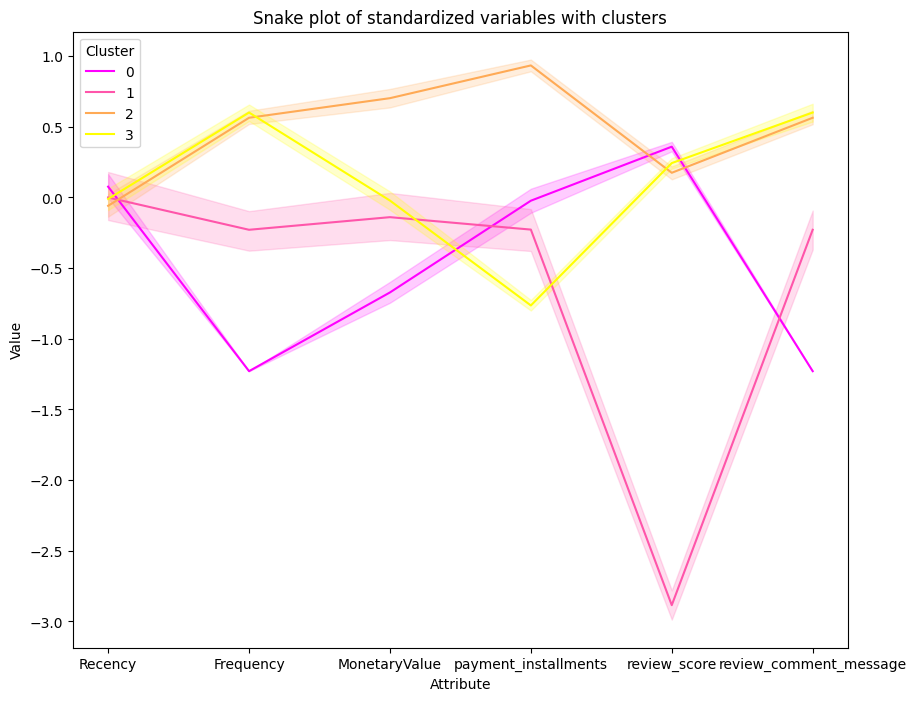

<Axes: title={'center': 'Snake plot of standardized variables'}, xlabel='Attribute', ylabel='Value'>

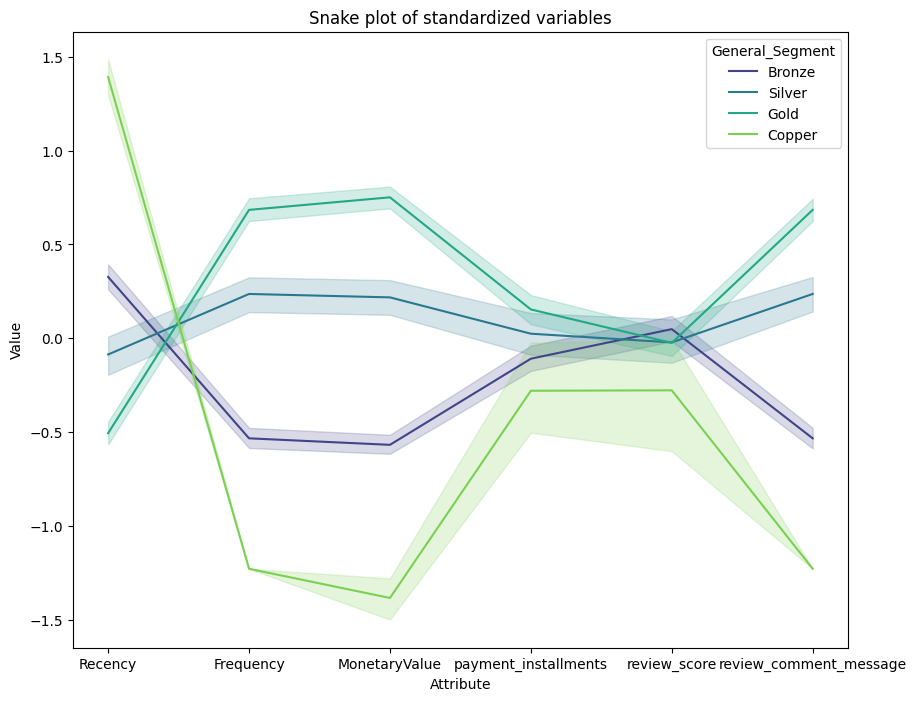

In [104]:
plt.figure(figsize = (10, 8))
plt.title('Snake plot of standardized variables with clusters')
plt.xlabel('Attribute')
plt.ylabel('Value')
sns.lineplot(x="Attribute", y="Value", hue='Cluster', data=data_melt, palette='spring')
plt.show()
plt.figure(figsize = (10, 8))
plt.title('Snake plot of standardized variables')
plt.xlabel('Attribute')
plt.ylabel('Value')
sns.lineplot(x="Attribute", y="Value", hue='General_Segment', data=data_melt_rfm_score, palette='viridis')


In [105]:
data_segment = data_normalized.assign(General_Segment = data['General_Segment'])
RFM['clusters'] = data['clusters']


C:\Users\litle\AppData\Local\Temp\ipykernel_30408\2803067917.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [106]:
cluster_avg = RFM.groupby(['clusters']).mean()
population_avg = RFM.mean()
relative_imp_cluster = cluster_avg / population_avg - 1
print(relative_imp_cluster.head())


segment_avg = data_segment.groupby(['General_Segment']).mean()

relative_imp_segment = segment_avg / population_avg - 1





          Frequency  MonetaryValue   Recency  clusters  payment_installments   
clusters                                                                       
0         -1.000000      -0.109917  0.002661       NaN             -0.021620  \
1         -0.186426      -0.022871 -0.000027       NaN             -0.209825   
2          0.458158       0.114714 -0.002090       NaN              0.859707   
3          0.488287      -0.003676 -0.000387       NaN             -0.704030   

          review_comment_message  review_score  
clusters                                        
0                      -1.000000      0.111697  
1                      -0.186426     -0.898215  
2                       0.458158      0.054190  
3                       0.488287      0.075565  


In [107]:
relative_imp_cluster = relative_imp_cluster[['Recency', 'Frequency', 'MonetaryValue', 'payment_installments', 'review_score', 'review_comment_message']]
relative_imp_cluster.round(2)


relative_imp_segment = relative_imp_segment[['Recency', 'Frequency', 'MonetaryValue', 'payment_installments', 'review_score', 'review_comment_message']]
relative_imp_segment.round(2)

,Recency,Frequency,MonetaryValue,payment_installments,review_score,review_comment_message
General_Segment,,,,,,
Bronze,-0.95,-1.92,-1.11,-1.12,-0.96,-1.92
Copper,-0.77,-3.11,-1.27,-1.31,-1.20,-3.11
Gold,-1.08,0.18,-0.86,-0.83,-1.02,0.18
Silver,-1.01,-0.59,-0.96,-0.97,-1.02,-0.59


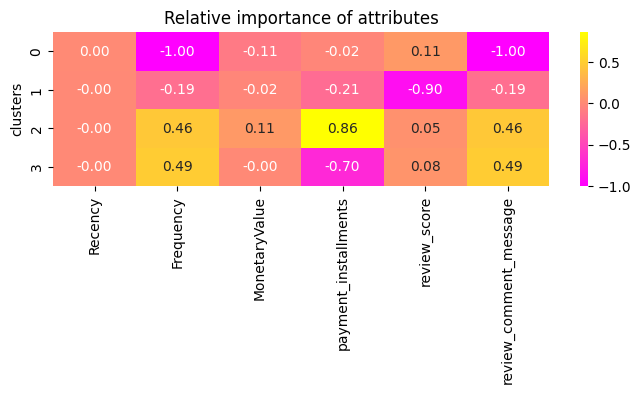

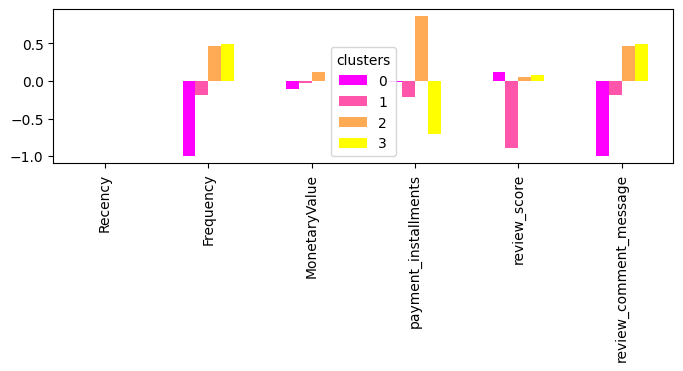

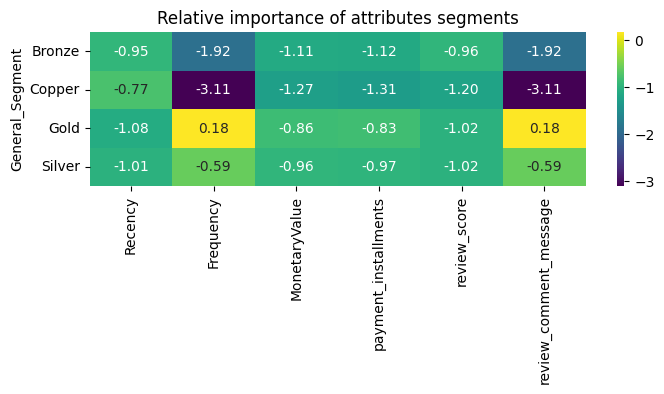

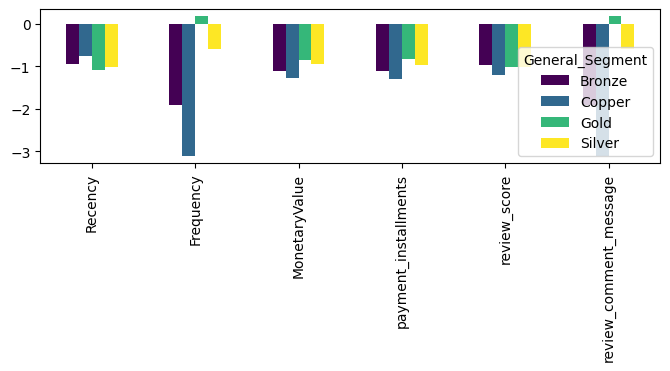

In [108]:
plt.figure(figsize=(8, 2))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp_cluster, annot=True, fmt='.2f', cmap='spring')
plt.show()
relative_imp_cluster.T.plot(kind='bar', figsize=(8, 2), cmap='spring')
plt.show()
plt.figure(figsize=(8, 2))
plt.title('Relative importance of attributes segments')
sns.heatmap(data=relative_imp_segment, annot=True, fmt='.2f', cmap='viridis')
plt.show()
relative_imp_segment.T.plot(kind='bar', figsize=(8, 2), cmap='viridis')
plt.show()
